In [1]:
import math

from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib


import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
import pipeline

from scipy.stats import ttest_ind

import geopandas as gpd

from scipy.stats import linregress
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison



import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
import pipeline



%matplotlib inline

!pwd

/home/barry/projects/covid_projects/fatality_analysis


# Loading Datasets
There are two key datasets: the usualy COVID dataset and a mortality dataset. Both are available from OWID.

## COVID Base

In [11]:
df = pd.read_pickle('../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max(), df.country.nunique()

((42838, 10), 208, Timestamp('2020-09-14 00:00:00'), 208)

In [12]:
df = df.pipe(lambda df: pipeline.compute_rolling(df, cols_like='new_'))



In [13]:
df['positivity_rate'] = df['new_cases_rolling']/df['new_tests_smoothed_rolling']
df['prevalence_ratio'] = (16*(df['positivity_rate']**.5))+2.5
df['new_infections_rolling'] = df['new_cases_rolling'] * df['prevalence_ratio']

In [14]:
df = df.pipe(pipeline.compute_per_100k)\
    .pipe(pipeline.compute_totals_per_100k)\

df.tail()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,new_deaths_rolling_per_100k,new_tests_smoothed_rolling_per_100k,new_infections_rolling_per_100k,total_cases_per_100k,total_deaths_per_100k,total_tests_smoothed_per_100k,total_cases_rolling_per_100k,total_deaths_rolling_per_100k,total_tests_smoothed_rolling_per_100k,total_infections_rolling_per_100k
42833,Zimbabwe,2020-09-10,ZWE,ZW,Africa,east_africa,41.0,4.0,649.0,14862927.0,...,0.015379,5.017277,6.635998,49.983425,1.493649,644.637493,47.539633,1.418983,639.946258,347.239475
42834,Zimbabwe,2020-09-11,ZWE,ZW,Africa,east_africa,24.0,0.0,NaN,14862927.0,...,0.015379,4.809506,6.552751,50.144901,1.493649,NaN,48.284535,1.434361,644.755764,353.792226
42835,Zimbabwe,2020-09-12,ZWE,ZW,Africa,east_africa,26.0,2.0,NaN,14862927.0,...,0.017301,4.667990,5.132334,50.319833,1.507106,NaN,48.901603,1.451662,649.423755,358.924560
42836,Zimbabwe,2020-09-13,ZWE,ZW,Africa,east_africa,29.0,0.0,NaN,14862927.0,...,0.017301,4.521317,5.509688,50.514949,1.507106,NaN,49.546544,1.468963,653.945071,364.434248
42837,Zimbabwe,2020-09-14,ZWE,ZW,Africa,east_africa,18.0,0.0,NaN,14862927.0,...,0.016340,4.411424,4.239216,50.636056,1.507106,NaN,50.074223,1.485303,658.356495,368.673464


# Estimating IFR

In [170]:
start_date = datetime(2020, 4, 1)
test_coverage_by_country = df.groupby('country').apply(lambda g: g.set_index('date').loc[start_date:]['new_tests_smoothed'].notnull().mean())

min_test_coverage = 0.9
countries_with_min_test_coverage = test_coverage_by_country[test_coverage_by_country>min_test_coverage].index

df_with_tests = df.set_index('country').loc[countries_with_min_test_coverage].reset_index()

df_with_tests = df_with_tests[df_with_tests['date']>=start_date].set_index('date')
df_with_tests.shape, df_with_tests['country'].nunique()

((13360, 29), 80)

## Weekly totals

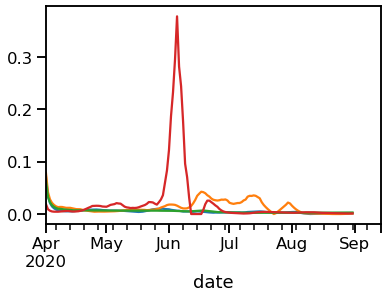

In [185]:
death_lag = -14

df_with_tests['new_infections_rolling_7d'] = df_with_tests.groupby('country')['new_infections_rolling'].transform(lambda v: v.rolling('7d').sum())
df_with_tests['new_deaths_rolling_7d_lagged'] = df_with_tests.groupby('country')['new_deaths_rolling'].transform(lambda v: v.rolling('7d').sum().shift(death_lag))


df_with_tests['ifr_lagged'] = df_with_tests['new_deaths_rolling_7d_lagged']/df_with_tests['new_infections_rolling_7d']


df_with_tests[df_with_tests['country']=='Denmark']['ifr_lagged'].plot()
df_with_tests[df_with_tests['country']=='Ireland']['ifr_lagged'].plot()
df_with_tests[df_with_tests['country']=='United States']['ifr_lagged'].plot()
df_with_tests[df_with_tests['country']=='Croatia']['ifr_lagged'].plot()

In [168]:
df_with_tests['new_infections_rolling']

50       789.943353
51       853.095498
52       665.621037
53       684.738707
54       869.164491
            ...    
18373    721.038267
18374    717.460904
18375    706.965556
18376    804.351703
18377    811.889595
Name: new_infections_rolling, Length: 13360, dtype: float64

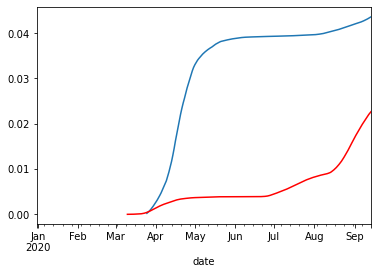

In [32]:
(df[df['country']=='Ireland'].set_index('date')['total_infections_rolling_per_100k']/100000).plot()
(df[df['country']=='Croatia'].set_index('date')['total_infections_rolling_per_100k']/100000).plot(c='r')

In [39]:
test_coverage_by_country = df.groupby('country').apply(lambda g: g.set_index('date').loc[datetime(2020, 4, 1):]['new_tests_smoothed'].notnull().mean())

min_test_coverage = 0.9
countries_with_min_test_coverage = test_coverage_by_country[test_coverage_by_country>min_test_coverage].index

In [118]:
df_with_tests = df.set_index('country').loc[countries_with_min_test_coverage]

continents = df_with_tests.groupby('country')['continent'].first()

total_cases_per_100k = df_with_tests.groupby('country')['total_cases_rolling_per_100k'].max()
total_deaths_per_100k = df_with_tests.groupby('country')['total_deaths_rolling_per_100k'].max()
total_infections_per_100k = df_with_tests.groupby('country')['total_infections_rolling_per_100k'].max()


total_cases = df_with_tests.groupby('country')['new_cases_rolling'].sum()
total_infections = df_with_tests.groupby('country')['new_infections_rolling'].sum()
total_deaths = df_with_tests.groupby('country')['new_deaths_rolling'].sum()

infection_gap = (total_infections-total_cases)/total_infections



cfr = total_deaths/total_cases
ifr = total_deaths/total_infections

np.corrcoef([infection_gap, ifr])

array([[ 1.        , -0.20765787],
       [-0.20765787,  1.        ]])

In [119]:
(total_deaths/total_infections).describe()

count    80.000000
mean      0.004102
std       0.003461
min       0.000161
25%       0.001961
50%       0.002920
75%       0.005294
max       0.019495
dtype: float64

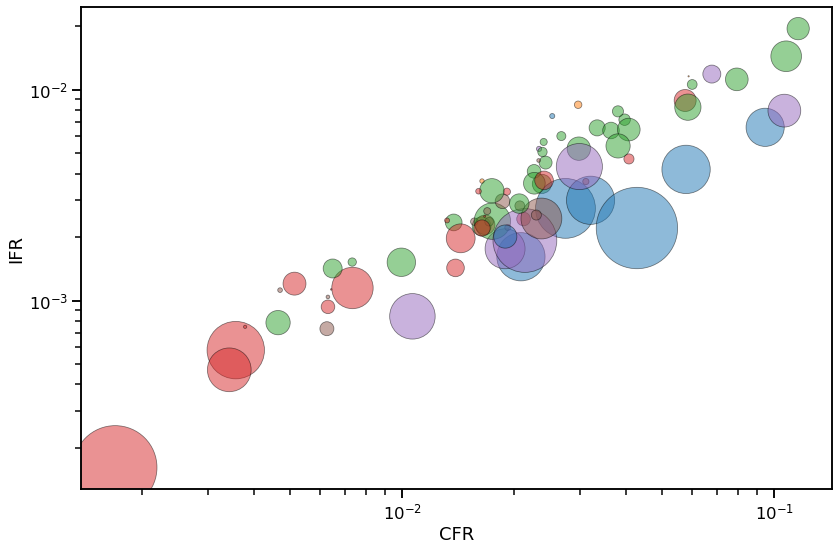

In [137]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(cfr, ifr, size=total_infections_per_100k, sizes=(0, 7000), hue=continents, alpha=.5, edgecolor='k', legend=False, ax=ax)
# sns.scatterplot(cfr, ifr, size=infection_gap, hue=continents, edgecolor='k', legend=False, ax=ax)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('CFR')
ax.set_ylabel('IFR')

fig.tight_layout()


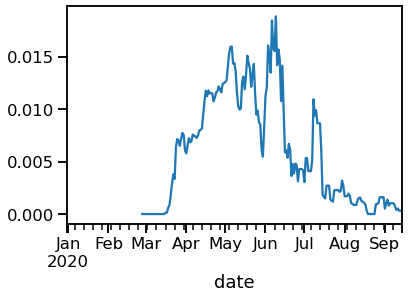

In [154]:
(df_with_tests.loc['Denmark'].set_index('date')['new_deaths_rolling']/df_with_tests.loc['Denmark'].set_index('date')['new_infections_rolling']).plot()

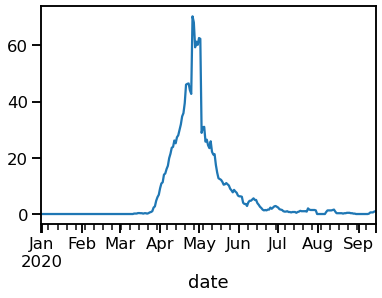

In [146]:
df_with_tests.loc['Ireland'].set_index('date')['new_deaths_rolling'].plot()

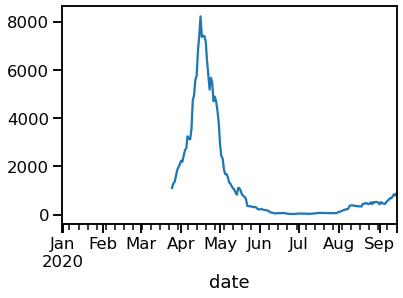

In [147]:
df_with_tests.loc['Ireland'].set_index('date')['new_infections_rolling'].plot()

## Only interested in countries with some COVID deaths.

In [294]:
deaths_by_country = df.groupby('country').apply(lambda g: g['total_deaths_per_100k'].max())

min_deaths = 0
min_pop = 0
countries_with_deaths = deaths_by_country[deaths_by_country>min_deaths].index

df = df[(df['country'].isin(countries_with_deaths)) & (df['population']>min_pop)].copy()
df.shape, df.country.nunique()

((39146, 22), 188)

## OWID Leading Causes of Death by Country
This dataset lists total deaths per year by a variety of cases and we can sum over the causes to calculate the total deaths per year for each country.

In [295]:
deaths_dataset = 'data/annual-number-of-deaths-by-cause.csv'

deaths = pd.read_csv(deaths_dataset).rename(columns={'Entity': 'country', 'Code': 'country_code', 'Execution': 'Execution (deaths)'})
deaths.shape, deaths.columns

((6686, 37),
 Index(['country', 'country_code', 'Year', 'Execution (deaths)',
        'Meningitis (deaths)', 'Lower respiratory infections (deaths)',
        'Intestinal infectious diseases (deaths)',
        'Protein-energy malnutrition (deaths)', 'Terrorism (deaths)',
        'Cardiovascular diseases (deaths)', 'Dementia (deaths)',
        'Kidney disease (deaths)', 'Respiratory diseases (deaths)',
        'Liver diseases (deaths)', 'Digestive diseases (deaths)',
        'Hepatitis (deaths)', 'Cancers (deaths)', 'Parkinson disease (deaths)',
        'Fire (deaths)', 'Malaria (deaths)', 'Drowning (deaths)',
        'Homicide (deaths)', 'HIV/AIDS (deaths)', 'Drug use disorders (deaths)',
        'Tuberculosis (deaths)', 'Road injuries (deaths)',
        'Maternal disorders (deaths)', 'Neonatal disorders (deaths)',
        'Alcohol use disorders (deaths)', 'Natural disasters (deaths)',
        'Diarrheal diseases (deaths)', 'Heat (hot and cold exposure) (deaths)',
        'Nutritional d

### Fill nulls so that we have the same number of causes per country

In [296]:
deaths = deaths.set_index(['country', 'country_code', 'Year']).fillna(0).reset_index()

### The Most Deaths x Cause

In [297]:
causes_of_death_by_country = deaths.sort_values(by='Year').groupby(['country', 'country_code']).last().drop('Year', axis=1).reset_index()
causes_of_death_by_country.head()

,country,country_code,Execution (deaths),Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Terrorism (deaths),Cardiovascular diseases (deaths),Dementia (deaths),...,Neonatal disorders (deaths),Alcohol use disorders (deaths),Natural disasters (deaths),Diarrheal diseases (deaths),Heat (hot and cold exposure) (deaths),Nutritional deficiencies (deaths),Suicide (deaths),Conflict (deaths),Diabetes (deaths),Poisonings (deaths)
0,Afghanistan,AFG,0,6588.668300,21431.163818,0.0,1369.742538,6092.0,56118.581876,2893.171202,...,27521.741242,125.474868,155.0,6176.201212,153.383019,1440.662274,1725.624776,1662.000127,5978.461720,365.394197
1,Albania,ALB,0,18.606850,381.653138,0.0,3.257634,0.0,12144.970442,1337.440187,...,183.685063,15.465368,1.0,6.939839,10.528083,4.458938,161.977426,0.000000,135.001529,11.384000
2,Algeria,DZA,0,379.614524,4723.762257,0.0,80.517066,12.0,79389.073241,8175.242117,...,6511.279864,130.332484,0.0,377.244709,50.093911,97.704089,1698.665146,134.999996,5201.535330,366.645603
3,American Samoa,ASM,0,0.731541,13.799033,0.0,1.468605,0.0,99.849458,8.453716,...,4.608330,0.344536,0.0,1.180293,1.142969,1.572362,3.481451,0.000000,33.245378,0.407851
4,Andorra,AND,0,0.256891,30.980068,0.0,0.135491,0.0,171.440664,56.321114,...,0.436309,1.870977,0.0,1.097464,0.377335,0.205362,8.186095,0.000000,5.269972,0.207766


### Expected Deaths per Year

In [298]:
expected_deaths_per_year = causes_of_death_by_country\
    .set_index(['country', 'country_code']).sum(axis=1).reset_index()\
    .set_index('country_code').drop('country', axis=1)\
    .rename(columns={0:'expected_deaths_per_year'})

expected_deaths_per_year.loc['IRL']

expected_deaths_per_year    29699.125957
Name: IRL, dtype: float64

In [299]:
df = df.set_index('country_code').join(expected_deaths_per_year).reset_index()
df.shape

(39146, 23)

### Expected Deaths/Day and per 100k
We simplify by assuming that the expected deaths are uniformly distributed across the days of the year.

In [300]:
df['expected_deaths_per_year_per_100k'] = df['expected_deaths_per_year']*100000/df['population']
df['expected_deaths_per_day'] = df['expected_deaths_per_year']/365.25
df['expected_daily_deaths_per_100k'] = 100000*df['expected_deaths_per_day']/df['population']

### COVID Days

In [301]:
date_of_first_death = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].iloc[0][['date']]
).rename(columns={'date': 'date_of_first_death'})


df = df.set_index('country').join(date_of_first_death).reset_index()

df['covid_days'] = (df['date']-df['date_of_first_death']).map(lambda d: d.days)

df.head()

,country,country_code,date,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,new_tests_smoothed_per_100k_rolling,total_cases_per_100k_rolling,total_deaths_per_100k_rolling,total_tests_smoothed_per_100k_rolling,expected_deaths_per_year,expected_deaths_per_year_per_100k,expected_deaths_per_day,expected_daily_deaths_per_100k,date_of_first_death,covid_days
0,Afghanistan,AFG,2019-12-31,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-84
1,Afghanistan,AFG,2020-01-01,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-83
2,Afghanistan,AFG,2020-01-02,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-82
3,Afghanistan,AFG,2020-01-03,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-81
4,Afghanistan,AFG,2020-01-04,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-80


## Excess Mortality

In [302]:
e = pd.read_csv('data/excess-mortality-p-scores.csv', parse_dates=['Date'])
e.columns = ['country', 'country_code', 'date', 'p']

e.head()

,country,country_code,date,p
0,Austria,AUT,2020-01-05,-11
1,Austria,AUT,2020-01-12,-8
2,Austria,AUT,2020-01-19,1
3,Austria,AUT,2020-01-26,2
4,Austria,AUT,2020-02-02,7


In [303]:
df = df.set_index(['country', 'date']).join(e.set_index(['country', 'date'])[['p']]).reset_index()

In [304]:
total_excess = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].set_index('date')[['p']].cumsum()
).rename(columns={'p':'total_excess_p'})



In [305]:
df = df.set_index(['country', 'date']).join(total_excess).reset_index()

df['mean_excess_p'] = df['total_excess_p']/df['covid_days']

# On Inconsistent Fatality Reporting
Before going any further it is worth confronting a central caveat of this work, namely inconsistencies in th eofficial COVID-19 fatality statistics for individual countries. It is not that the numbers are inaccurate per se, rather they mean different things because they arise from [many different reporting approaches](https://www.spectator.co.uk/article/it-s-a-mistake-to-compare-our-covid-deaths-with-spain-and-france). Some countries only count deaths that arise from a confirmed COVID test, others have limired their focus to hospital settings, while yet others have been far more inclusive, counting suspected and confirmed deaths in all settings to be counted. These differences were especially prevalent during the early stages of the pandemic, and while many countries have at least addressed some of the obvious shortcomings in their early counting (e.g. hospital deaths only) inconsistencies do remain.

This is problematic given the central aim of this work, which is to compare the COVID-19 burden, a relative fatility estimate that is based on these inconsistent fatality numbers. However, we can at lest shed some light on the the scale of the problem by comparing official COVID-19 fatality statsitics to so-called excess mortality statistics, using all-cause mortality differences between 2020 and previous years. Excess mortality provide an estimate of the additional deaths this year so far, regardless of cause, by comparing total numbers of deaths in 2020 to historical averages. The problem is that excess mortality estimates are difficult to come by and are only readily available for a small subset of the countries in our dataset, but it's enough to at least gain some useful insight into the level of inconsistency that likley exists.

## Correlation between excess deaths and total deaths ...
Ideally, we should expect to find a strong correlation between excess deaths and official deaths per capital. In fact, when we calculate the strength of this relationship using 27 countries in which excess deaths are available (based on a 27 country excess deaths dataset from OWID) we find a correlation coefficient of 0.89, indicating a reasonably strong correlation between excess deaths and official fatality numbers; this corresponds to a so-called r-squared number of approximately 0.8 meaning that 80% of the variation in excess deaths can be explained by the official fatality numbers. 

This is not a perfect correlation, and it allows for some countries to be outliers, but it does suggest that, in general, the official fatality numbers are likely to provide a reasonably coherent basis for the COVID-19 burden. The graph below shows this correlation visually as a plot of official fatalities versus excess deaths for each of the 27 countries. Note that excess deaths is measued here as the sum of the daily percentage increase in excess deaths, relative to historical norms; Belgium gas a total excess of 380% based on an average daily excess of 2.5% during the duration of its outbreak. 

Most countries fall close to the linear regression line used to estimate the relationship between these two fatality parameters, but Belgium is the obvious outlier. It's official fatalities (>80 per 100k) are very high in comparison to aother countries with similar excess deaths. Given that Belgium is the outlier it suggests that its official fatality estimate is too high and needs to be reduced (by almost 40%) to bring it inline with others, and such an adjustment will have a corresponding effect on Belgium's COVID-19 burden, as we will see. In a similar way, the official fataility estimate from the UK may be too low given it should be increased by approximately 12%.

The take-home, is that although inconsistencies remain in the way that official COVID-19 fatalities are recorded, most of the time the degree of inconsistency is modest (<20%) but it does point to the need for caution when comparing countries when their fatality counts differ by a similar amount, beuase such differences may be arise because of reporting differences rather than a fundamental difference in actual COVID-19 related deaths.

In [306]:
df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p', 'mean_excess_p']].loc['Belgium']

total_deaths_per_100k     85.585234
total_excess_p           380.000000
mean_excess_p              2.516556
Name: Belgium, dtype: float64

In [307]:
df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p']].corr().values[0][1]

0.8973809479362566

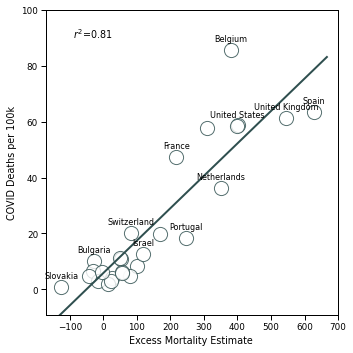

In [308]:
sns.set_context('paper')

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot('total_excess_p', 'total_deaths_per_100k', data=df.groupby('country').last(), 
            ci=False, truncate=False,
            scatter_kws=dict(edgecolor='darkslategrey', facecolor='w', s=200), 
            line_kws=dict(color='darkslategrey', lw=2))

show_countries = [
    'Spain', 'United Kingdom', 'United States', 'France', 'Netherlands', 'Portugal', 'Bulgaria', 'Slovakia',
    'Israel', 'Switzerland', 'Belgium'
]

df.groupby('country').last().reindex(show_countries).apply(
    lambda row: ax.text(row['total_excess_p'], row['total_deaths_per_100k']+4, row.name, fontsize=8, ha='center', va='center'), axis=1
)

ax.set_ylim(-9, 100)
ax.set_xlim(-170, 700)

ax.set_xlabel('Excess Mortality Estimate ')
ax.set_ylabel('COVID Deaths per 100k')

ax.text(-90, 90, '$r^2$={}'.format(
    round(df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p']].corr().values[0][1]**2, 2)))

fig.tight_layout()

fig.savefig('graphs/covid_excess_correlation.png', dpi=300, format='png')

In [309]:
excess = df.groupby('country').last()[['total_excess_p', 'total_deaths_per_100k']].dropna()
x, y = excess['total_excess_p'], excess['total_deaths_per_100k']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

def est_total_deaths_per_100k(p):
    return (slope*p) + intercept

(np.abs((x.map(est_total_deaths_per_100k)-y))/y)

country
Austria            1.072080
Belgium            0.416560
Bulgaria           0.757407
Czech Republic     1.127008
Denmark            0.095511
Estonia            2.114826
Finland            1.013159
France             0.342256
Germany            0.055760
Hungary            0.671063
Iceland            0.368703
Israel             0.534178
Italy              0.110654
Latvia             3.098899
Lithuania          1.664556
Luxembourg         0.279658
Netherlands        0.278003
Norway             0.820028
Poland             1.143917
Portugal           0.885529
Slovakia          13.565147
Slovenia           0.124242
Spain              0.238690
Sweden             0.277604
Switzerland        0.241868
United Kingdom     0.126489
United States      0.107080
dtype: float64

# The % COVID Burden
The covid burden is simply the a percentage based on the ratio of covid deaths to expected deaths on a given day.

In [310]:
total_expected_deaths = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].set_index('date')[['expected_daily_deaths_per_100k']].cumsum()
).rename(columns={'expected_daily_deaths_per_100k':'total_expected_deaths_per_100k'})

df = df.reset_index().set_index(['country', 'date']).join(total_expected_deaths).reset_index()

df['covid_burden'] = 100*df['total_deaths_per_100k']/df['total_expected_deaths_per_100k']
df['covid_burden'] = df['covid_burden'].replace(np.inf, np.nan)

df['annual_covid_burden'] = 100*df['total_deaths_per_100k']/df['expected_deaths_per_year_per_100k']
df['annual_covid_burden'] = df['annual_covid_burden'].replace(np.inf, np.nan)

# The Tadpole Graph

In [311]:
def plot_tail(ax, g, lw, width_scale=0.006, *args, **kwargs):
    g_next = g.shift(-1).add_suffix('_next')
    g = pd.concat([g, g_next], axis=1)
    
    for i, (_, (x, y, x_next, y_next)) in enumerate(g[:-1].iterrows()):
        ax.plot([x, x_next], [y, y_next], lw=lw*width_scale*i/len(g), **kwargs)

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


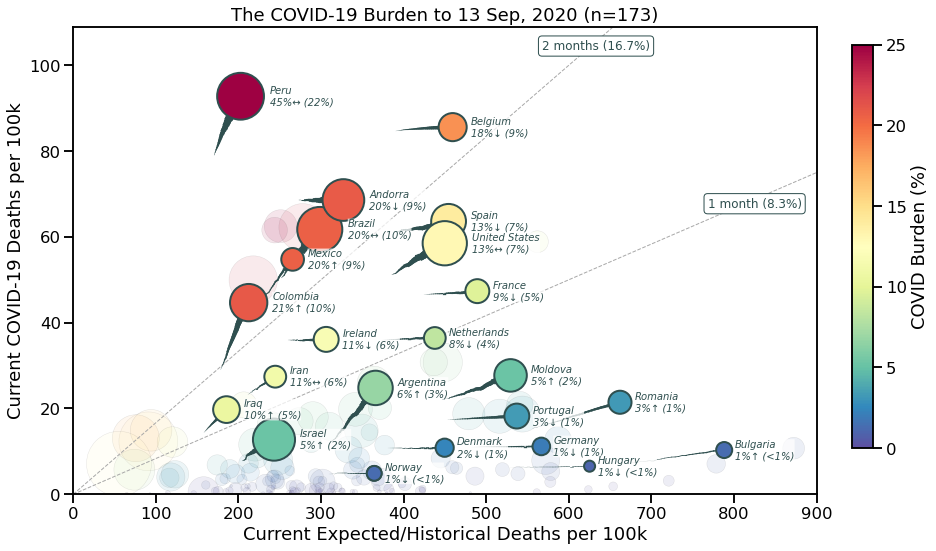

In [312]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))

# ax.grid(b='both', lw=.5, ls='--')

tail_length = 30  # The number of days to use for the tail of the tadpoles

# The colour map to use for the tadpole heads
use_palette = 'Spectral_r'

# The countries to highlight
show_countries = [
    'Peru', 'Belgium', 'Spain', 'Mexico', 'United States',
    'Ireland', 'France', 
    'Bulgaria', 
    'Iran', 'Israel', 'Brazil', 'Argentina', 'Norway', 'Andorra', 'Iraq',
    'Germany', 'Portugal', 'Netherlands', 'Norway', 'Denmark', 'Romania',
    'Moldova', 'Colombia', 'Hungary'
]

def plot_tadpoles(
    ax, df, 
    x='total_expected_deaths_per_100k', y='total_deaths_per_100k', size='total_cases_per_100k',
    use_palette=use_palette, show_countries=show_countries):
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=25)
    cmap = matplotlib.cm.get_cmap(use_palette)
    
    in_show_countries = df['country'].isin(show_countries)


    # Plot the tadpole tails

#     df.groupby('country').apply(
#         lambda g: plot_tail(
#             ax, 
#             g[[x, y]].tail(tail_length),
#             g[size].max(), c='lightgrey', zorder=-200, alpha=.2
#         )    
#     )


    df[in_show_countries].groupby('country').apply(
        lambda g: plot_tail(
            ax, 
            g[[x, y]].tail(tail_length),
            g[size].max(), c='darkslategrey', zorder=-10
        )    
    )

    # Plot the tadpole heads using the current covid burden.
    current_df = df.groupby('country').last().copy().dropna(subset=['covid_burden'])

    # Add the previous total_deaths_per_100k at start of tail.
    prev_total_deaths_per_100k = df.groupby('country').apply(
        lambda g: g[[y]].iloc[-tail_length]).rename(columns={y: 'prev_'+y})
    prev_covid_burden = df.groupby('country').apply(
        lambda g: g[['covid_burden']].iloc[-tail_length]).rename(columns={'covid_burden': 'prev_covid_burden'})

    
    current_df = current_df.join(prev_total_deaths_per_100k).join(prev_covid_burden)
    current_df[y+'_trend'] = (current_df[y]-current_df['prev_'+y])/current_df['prev_'+y]
    current_df['covid_burden_trend'] = (current_df['covid_burden']-current_df['prev_covid_burden'])/current_df['prev_covid_burden']


    all_colours = [cmap(norm(i)) for i in current_df['covid_burden']]
    marker_colours = [cmap(norm(i)) for i in current_df.reindex(show_countries)['covid_burden']]

    # The background heads
    ax.scatter(x, y, data=current_df,
               s=size, c=all_colours, edgecolor='k', lw=.5, alpha=.1, zorder=-100)

    # The coloured heads for the highlight countries.
    ax.scatter(x, y, data=current_df.reindex(show_countries),
               s=size, c=marker_colours, edgecolor='darkslategrey', lw=2, alpha=1)


    # Add the burden lines

    ax.set_xlim(0, 900)  
    
    def label_burden_line(x, burden):

        # Setup the label
        n = burden*12
        period = 'weeks' if n<1 else 'months'
        n = n*4 if n<1 else n
        period = 'month' if n==1 else period
        label = '{} {} ({}%)'.format(int(n), period, round(burden*100, 1))

        # Calculate the rotation angle
        y = 0.5+x*burden
        ax.text(
            x, y, label, 
            color='darkslategrey', ha='center', va='top', fontsize=12,
            bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),

    )


    for xpos, frac in [(825, 1/12), (633, 1/6)]:
        ax.plot(ax.get_xlim(), np.array(ax.get_xlim())*frac, c='darkgrey', lw=1, ls='dashed', zorder=-100)
        label_burden_line(xpos, frac)


    # Annotate highlight countries
    for country, row in current_df.iterrows():
        if country in show_countries:

            xpos, ypos = row[x], row[y]
            s = row[size]
            r = (s/2)**.5
            i = row['covid_burden']
            i = '<1' if i<1 else int(i)
            
            c = row['annual_covid_burden']
            c = '<1' if c<1 else int(c)

            
            if -.05 < row['covid_burden_trend'] < 0.05:
                dir_arrow = '↔'
            elif row['covid_burden_trend'] > 0.05:
                dir_arrow = '↑'
            else:
                dir_arrow = '↓'
                    
            label = '{}\n{}%{} ({}%)'.format(country, i, dir_arrow, c)

            ax.text(
                xpos+r+2, ypos, label, 
                fontsize=10, ha='left', va='center', color='darkslategrey', style='oblique',
                bbox=dict(facecolor='w', boxstyle='round,pad=0', lw=0, alpha=.75),
            )

    # Show the colourmap
    cax = fig.add_axes([1, .2, 0.025, .7])
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
    cb.set_label('COVID Burden (%)')

    return current_df

current_df = plot_tadpoles(ax, df)


# Finalise the axes
ax.set_xlim(0, 900)
ax.set_ylim(0, 109)

ax.set_xlabel('Current Expected/Historical Deaths per 100k')
ax.set_ylabel('Current COVID-19 Deaths per 100k')

ax.set_title('The COVID-19 Burden to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))






fig.tight_layout()
fig.savefig('graphs/covid_burden_tadpoles.png', dpi=300, format='png', bbox_inches='tight')

Here we see COVID deaths versus the expected deaths (both per 100,000 of population) over the same period of time. Each country is represented by a single marker (the head) with a tail, just like a tadpole. The size of the head is proportional to confirmed cases per capita and coloured according to its COVID burden, as per the scale shown. The tails indicate the trajectories of deaths for a country over the previous 30 days and, as such, help to highlight countries where deaths have been increasing (tails with an upward trajectory) and countries where deaths have been absent (horizontal tails). For example, countries such as Peru, the US, Israel, and Romania have tails that are indicative of increasing deaths -- the steeper the angle the greater the rate of increase -- whereas Ireland, the Netherlands, France, and Germany have tails that are horizontal, indicating no material increase in COVID deaths over the past 30 days.

Over time, all of the countries will move from the left to the right, as their expected number of deaths increases with each passing day, and they can move upwards as new COVID fatalities are registered, but they cannot move from right to left or downwards. 

Currently, most of the highlighted countries are associated with outbreaks that have been propgressing for 170-180 days and so their x-axis position reflects approximately 50% of their annual expected death rate; there is quite a bit of variation in these annual figures, even within similar regions. 

The diagonal guidelines on the graph show the trajectories associated with different COVID burden levels. For example, earlier we mentioned the hypothesis that COVID fatalities would be limited to approximately 1 month's worth of deaths for a given country. In fact, approximately 85% of the 173 countries analysed have a current COVID burden that is less than this level and the mean COVID burden is just under 4% currently. In other words only a minority of countries have exceeded this level today, adding some creedence to this hypotehsis; although while other factors explain higher rates, South American countries in particular appear to have accummulated significantly more that one month's worth of deaths. 

Currently, most countries (>70%) are experiencing rising fatality rates relative to a month ago, which means that their COVID burden is growing, although the rate of growth is much lower (23%) among those countries with a COVID Burden >12% compared with the rate of growth (70%) among those countries COVID burdens <12%.

This graph highlights some of the very different outbreak experiences around the world, but we do need to be mindful that differenceshows deaths are counted will account for at least some of the variance we see in the COVID burden and per capita death tolls. Nonetheless, it is worth highlighting countries such as Brazil, Mexico, Peru, all of which have growing COVID burdens of at least 20%. Peru presents with COVID burden of 46%, which is exceedingly high by any objective standard and is unlikely to be explained away but accounting differences, moreover, Peru's death toll has been increasing rapidly over the past month.

In comparison, most European countries have much lower COVID burdens, and in most of those shown, which do have higher burdens (Spain, France, Ireland, the Netherlands), COVID deaths have not been increasing significantly over the past month. In fact, overall only 50% of European countries are experiencing a COVID burden that has increased by more than 5% over the past 30 days, compared with 80% in North America and 100% in South America; by this measure Europe is leading the world.

In [328]:
current_df.loc['IRL']

country                                              Ireland
date                                     2020-09-13 00:00:00
index                                                  17417
country_id                                                IE
continent                                             Europe
region                                                    eu
new_cases                                                159
new_deaths                                                 2
new_tests_smoothed                                     10253
population                                        4.9378e+06
new_cases_per_100k                                   3.22006
new_deaths_per_100k                                0.0405039
new_tests_smoothed_per_100k                          207.643
total_cases_per_100k                                 622.342
total_deaths_per_100k                                36.1092
total_tests_smoothed_per_100k                        18152.7
new_cases_per_100k_rolli

In [330]:
1778/(30000*185/365)

0.11693153153153153

## Fraction of countries with different burdens

In [313]:
(current_df['covid_burden']<100/12).mean()

0.8554913294797688

In [314]:
(current_df['covid_burden']>100/6).mean()

0.06358381502890173

# Rank COVID Burden
Where does a country's covid burden rank in terms of the common causes of death for that country. CUrrently we only do this for the current covid burden using `current_df` rather than `df`.

## Compute the COVID rank

In [315]:
total_covid_deaths_by_country_code = df.groupby('country_code')[['new_deaths']].sum().rename(columns={'new_deaths': 'covid (deaths)'})
total_covid_deaths_by_country_code.loc['IRL']

covid (deaths)    1783.0
Name: IRL, dtype: float64

In [316]:
causes_of_death_by_country_with_covid = causes_of_death_by_country.set_index('country_code').join(total_covid_deaths_by_country_code).reset_index()
causes_of_death_by_country_with_covid.sample()

,country_code,country,Execution (deaths),Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Terrorism (deaths),Cardiovascular diseases (deaths),Dementia (deaths),...,Alcohol use disorders (deaths),Natural disasters (deaths),Diarrheal diseases (deaths),Heat (hot and cold exposure) (deaths),Nutritional deficiencies (deaths),Suicide (deaths),Conflict (deaths),Diabetes (deaths),Poisonings (deaths),covid (deaths)
105,LBY,Libya,0,70.591716,842.096677,0.0,13.147519,289.0,13334.419934,1508.067473,...,39.274553,0.0,65.317434,8.810682,16.575797,578.415679,1525.000078,1404.877163,75.242011,354.0


In [317]:
# The number of >0 causes
max_causes = pd.DataFrame(causes_of_death_by_country_with_covid.apply(lambda row: len(row.filter(like='(deaths)')[row.filter(like='(deaths)')>0]), axis=1)).rename(columns={0:'max_rank'})

# The rank of each >0 cause
rank_causes = causes_of_death_by_country_with_covid.apply(
    lambda row: 1+(len(row.filter(like='(deaths)')[row.filter(like='(deaths)')>0])-row.dropna().filter(like='(deaths)')[row.dropna().filter(like='(deaths)')>0].rank()), axis=1).add_suffix('_rank')

covid_rank_by_country_code = pd.concat([causes_of_death_by_country_with_covid, rank_causes, max_causes], axis=1).set_index('country_code')

covid_rank_by_country_code.loc['IRL']

country                                    Ireland
Execution (deaths)                               0
Meningitis (deaths)                        13.0685
Lower respiratory infections (deaths)      1371.93
Intestinal infectious diseases (deaths)          0
                                            ...   
Suicide (deaths)_rank                            9
Terrorism (deaths)_rank                        NaN
Tuberculosis (deaths)_rank                      21
covid (deaths)_rank                              5
max_rank                                        29
Name: IRL, Length: 70, dtype: object

## Add Rank & Days
We also compute a relative rank here, given that different countries/regions can have different numbers of non-zero causes.

In [318]:
current_df = current_df.reset_index().set_index('country_code').join(covid_rank_by_country_code[['covid (deaths)_rank', 'max_rank']]).rename(columns={'covid (deaths)_rank': 'covid_rank'})

current_df['rel_covid_rank'] = current_df['covid_rank']/current_df['max_rank']
current_df.loc['AUS']

country                                            Australia
date                                     2020-09-13 00:00:00
index                                                   2160
country_id                                                AU
continent                                            Oceania
region                                           australasia
new_cases                                                 42
new_deaths                                                 6
new_tests_smoothed                                     65522
population                                       2.54999e+07
new_cases_per_100k                                  0.164707
new_deaths_per_100k                                0.0235295
new_tests_smoothed_per_100k                           256.95
total_cases_per_100k                                 104.342
total_deaths_per_100k                                3.14903
total_tests_smoothed_per_100k                        25525.1
new_cases_per_100k_rolli

# Analysis by Continent

## Statististical Significance Tests

In [319]:
def check_contintent_significance(current_df, group_col='continent', result_col='expected_deaths_per_year_per_100k', p=.05):
    
    grouped_results = current_df.groupby(group_col).apply(lambda g: g[result_col].dropna().values)
    f = f_oneway(*grouped_results)
    
    if f.pvalue>p: return f, None
    
    else:
        stacked_data = current_df.groupby(group_col).apply(lambda g: pd.Series(g[result_col].dropna().values))
        stacked_data = stacked_data.unstack(-2).stack().reset_index()
        stacked_data.columns = ['id', 'group', 'result']

        tukey = MultiComparison(stacked_data['result'], stacked_data['group']).tukeyhsd()
        return f, tukey
    
f, tukey = check_contintent_significance(current_df, group_col='continent', result_col='covid_burden', p=.05)
f, print(tukey.summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
       Africa          Asia   2.5408 0.2378  -0.7715   5.853  False
       Africa        Europe   3.7329  0.021   0.3539  7.1119   True
       Africa North America   4.8129 0.0128   0.6647   8.961   True
       Africa       Oceania    0.281    0.9  -6.6239  7.1859  False
       Africa South America  13.9126  0.001   8.7796 19.0457   True
         Asia        Europe   1.1921    0.9  -2.3223  4.7066  False
         Asia North America   2.2721 0.6216  -1.9871  6.5313  False
         Asia       Oceania  -2.2597    0.9  -9.2319  4.7125  False
         Asia South America  11.3719  0.001   6.1487 16.5951   True
       Europe North America     1.08    0.9  -3.2313  5.3912  False
       Europe       Oceania  -3.4519 0.6887  -10.456  3.5523  False
       Europe South America  10.1797  0.001   4.

(F_onewayResult(statistic=13.194441386308812, pvalue=7.815339185822273e-11),
 None)

## Comparison of Continents

In [320]:
current_df['covid_burden_trend_increasing'] = current_df['covid_burden_trend']>0


use_cols = ['covid_burden', 'covid_burden_trend', 'covid_burden_trend_increasing', 'covid_rank', 'rel_covid_rank', 'covid_days', 'max_rank', 'total_deaths_per_100k', 'total_cases_per_100k', 'expected_deaths_per_year_per_100k']

burden_by_continent = current_df.dropna(subset=use_cols).groupby('continent')[use_cols].agg(['count', 'mean', 'std']).sort_values([('covid_rank', 'mean')], ascending=True)
burden_by_continent

covid_burden                       covid_burden_trend            \
                     count       mean        std              count      mean   
continent                                                                       
South America           12  14.853071  14.032354                 12  0.624067   
Europe                  40   4.673354   5.348688                 40 -0.026121   
North America           21   5.753316   6.282926                 21  0.653706   
Asia                    43   3.481204   4.802595                 43  0.145276   
Oceania                  6   1.221491   1.605443                  6  0.529663   
Africa                  51   0.940453   1.338153                 51  0.127049   

                        covid_burden_trend_increasing                      \
                    std                         count      mean       std   
continent                                                                   
South America  0.828799                            12  0.750000  0.452267   
Europe         0.160829                            40  0.325000  0.474342   
North America  1.332833                            21  0.666667  0.483046   
Asia           0.439969                            43  0.488372  0.505781   
Oceania        1.362587                             6  0.333333  0.516398   
Africa         0.441623                            51  0.431373  0.500196   

              covid_rank  ...  max_rank total_deaths_per_100k             \
                   count  ...       std                 count       mean   
continent                 ...                                              
South America         12  ...  0.900337                    12  36.933167   
Europe                40  ...  0.716115                    40  21.077330   
North America         21  ...  1.016530                    21  16.915488   
Asia                  43  ...  1.527525                    43   5.797881   
Oceania                6  ...  0.836660                     6   3.703938   
Africa                51  ...  1.189167                    51   2.337976   

                         total_cases_per_100k                           \
                     std                count         mean         std   
continent                                                                
South America  31.024869                   12  1038.233610  793.054145   
Europe         22.121581                   40   522.989231  359.075006   
North America  17.395538                   21   633.764298  636.944784   
Asia            7.301283                   43   600.743184  924.807840   
Oceania         5.645719                    6   228.035939  439.529961   
Africa          3.993260                   51   139.431477  216.145976   

              expected_deaths_per_year_per_100k                           
                                          count         mean         std  
continent                                                                 
South America                                12   591.981284  145.440582  
Europe                                       40  1034.147250  280.806115  
North America                                21   674.232892  228.525155  
Asia                                         43   532.460404  241.753136  
Oceania                                       6   684.967699  145.560549  
Africa                                       51   636.015278  171.379658  

[6 rows x 30 columns]

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


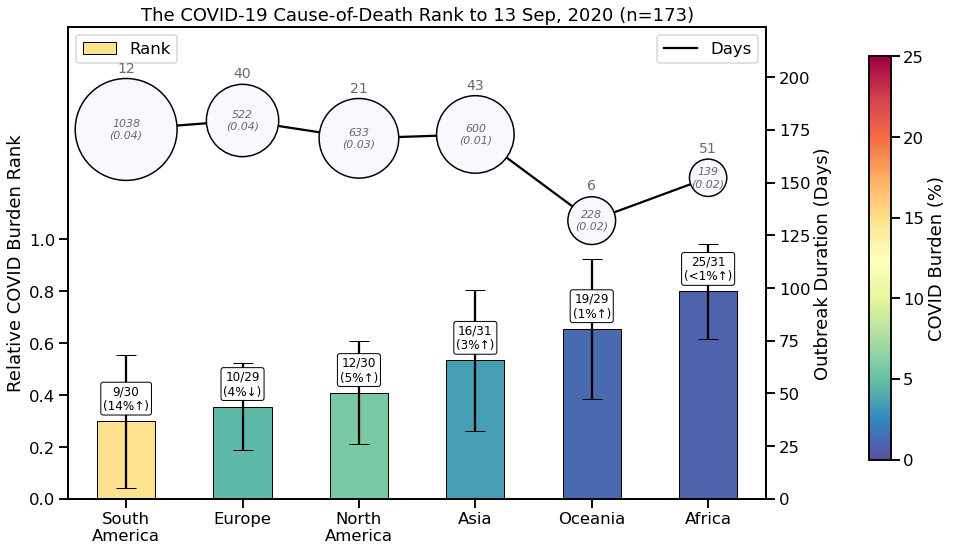

In [321]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))
bx=ax.twinx()


norm = matplotlib.colors.Normalize(vmin=0, vmax=25)
cmap = matplotlib.cm.get_cmap(use_palette)


# The colour map; because we shade the bars based on their average covid burden
bar_colours = [cmap(norm(i)) for i in burden_by_continent['covid_burden']['mean']]

# The main bar chart
burden_by_continent['rel_covid_rank']['mean'].plot(
    ax=ax, kind='bar', lw=1, edgecolor='k', color=bar_colours, 
    yerr=burden_by_continent['rel_covid_rank']['std'], capsize=10
)

# The days line graph
burden_by_continent['covid_days']['mean'].plot(ax=bx, c='k', zorder=-10)
bx.scatter(
    burden_by_continent.index, burden_by_continent['covid_days']['mean'], 
    s=burden_by_continent['total_cases_per_100k']['mean']*10, 
    color='ghostwhite', edgecolor='k'
)

burden_by_continent.apply(
    lambda row: bx.text(
        row.name, 
        row['covid_days']['mean']+(1+(row['total_cases_per_100k']['mean']*1)**.46), 
        int(row['covid_days']['count']), 
        ha='center', va='bottom', color='dimgrey', fontsize=14),
    axis=1
)

burden_by_continent.apply(
    lambda row: bx.text(
        row.name, 
        row['covid_days']['mean'], 
        '{}\n({})'.format(
            int(row['total_cases_per_100k']['mean']),
            round(row['total_deaths_per_100k']['mean']/row['total_cases_per_100k']['mean'], 2),
        ),
        ha='center', va='center', color='dimgrey', style='oblique', fontsize=11),
    axis=1
)

# The colour bar
cax = fig.add_axes([1.02, .18, 0.025, .7])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')

# Add rank labels.
for i, (continent, row) in enumerate(burden_by_continent.iterrows()):
    
    mean_covide_rank = int(round(row['covid_rank']['mean'], 1))
    mean_covid_max_rank = int(round(row['max_rank']['mean'], 1))
    
    mean_covid_burden = int(row['covid_burden']['mean'])
    mean_covid_burden = '<1' if mean_covid_burden==0 else mean_covid_burden
    trend_arrow = '↑' if row['covid_burden_trend']['mean']>0 else '↓'

    ax.text(
        i, row['rel_covid_rank']['mean']+.033, '{}/{}\n({}%{})'.format(
            mean_covide_rank, 
            mean_covid_max_rank,
            mean_covid_burden,
            trend_arrow
        ),
        ha='center', va='bottom', fontsize=12,
        bbox=dict(facecolor='w', boxstyle='round,pad=.2', lw=1, alpha=1),


    )


ax.set_ylim(0, 1.82)
ax.set_yticks(np.arange(0, 1.1, .2))
bx.set_ylim(0, 224)

ax.set_ylabel('Relative COVID Burden Rank')
bx.set_ylabel('Outbreak Duration (Days)')
ax.set_xlabel('')

ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=0)

ax.legend(['Rank'], loc='upper left')
bx.legend(['Days'], loc='upper right')

ax.set_title('The COVID-19 Cause-of-Death Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))


fig.tight_layout()

fig.savefig('graphs/covid_burden_by_continent_bar.png', dpi=300, format='png', bbox_inches='tight')

To put this COVID burden in context, we use information on the number of fatalities per country per year across a variety of causes (e.g. cardiovascular disease, cancer, respiratory disease etc.) in order to rank COVID relative to these common causes of death. Not every country is associated with the same number of causes, so we convert this rank into a relative rank, such that a relative rank of 0 means that COVID is the leading single cause of death (acknowledging that is is problematic given co-morbidities etc.) in a particular country, while a relative rank of 1 means that it is the least common cause of death in that country.

The graph above shows the average relative rank for each continent as the bars (with corresponding standard deviations). The colour coding for the bars is based on the mean COVID burden for the corresponding continent, using the same colour-scale as previously. Each bar is also annotated with the average actual rank (not the relative rank) for the corresponding continent. The line graph presents the average number days since the first COVID death was registered in each continent alongwith th enumber of countries associated with each continent in our dataset. We can see that COVID ranks in the top-10 causes of deaths currently in South America and Europe, compared to top-20 and top-30 in Oceania and Africa, where there have been been fewer COVID-days.

# Rank/Burden x Country
Next, let's look at the country burdens and their corersponding ranks.

In [322]:
map = gpd.read_file('data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin').rename(columns={'ADM0_A3':'country_code'})

map_with_data = map.set_index('country_code').join(current_df[['covid_burden', 'covid_rank', 'max_rank', 'continent', 'region', 'population']])

map_with_data['coords'] = map_with_data['geometry'].apply(lambda x: x.representative_point().coords[0])


/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


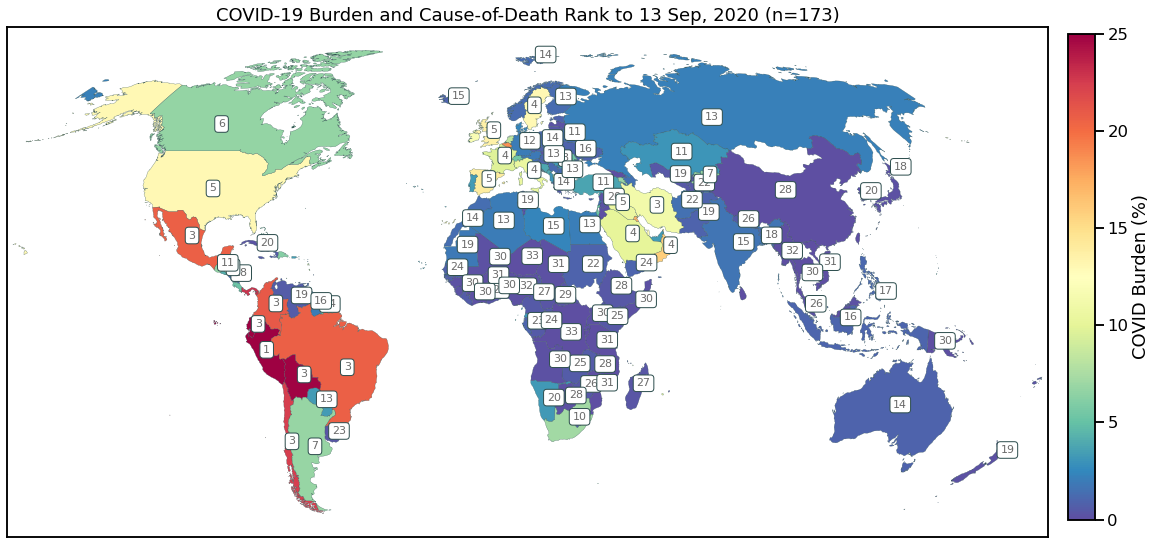

In [323]:
fig, ax = plt.subplots(figsize=(15, 15))

map_with_data.plot(column='covid_burden', cmap=use_palette, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
min_area = 9.1e10

map_with_data[map_with_data['covid_rank'].notnull()].apply(
    lambda row: ax.annotate(
        '{}'.format(int(row['covid_rank'])), xy=row['coords'], fontsize=11, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)


    
ax.set_xlim(-1.5e7,1.7e7)



ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])


cax = fig.add_axes([1, .28, 0.025, .45])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')

ax.set_title('COVID-19 Burden and Cause-of-Death Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))

fig.tight_layout()

fig.savefig('graphs/covid_burden_world_map.png', dpi=300, format='png', bbox_inches='tight')

This map and the version below show the COVID rank for individual countries with each country coliour coded based on it's current COVID burden.

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


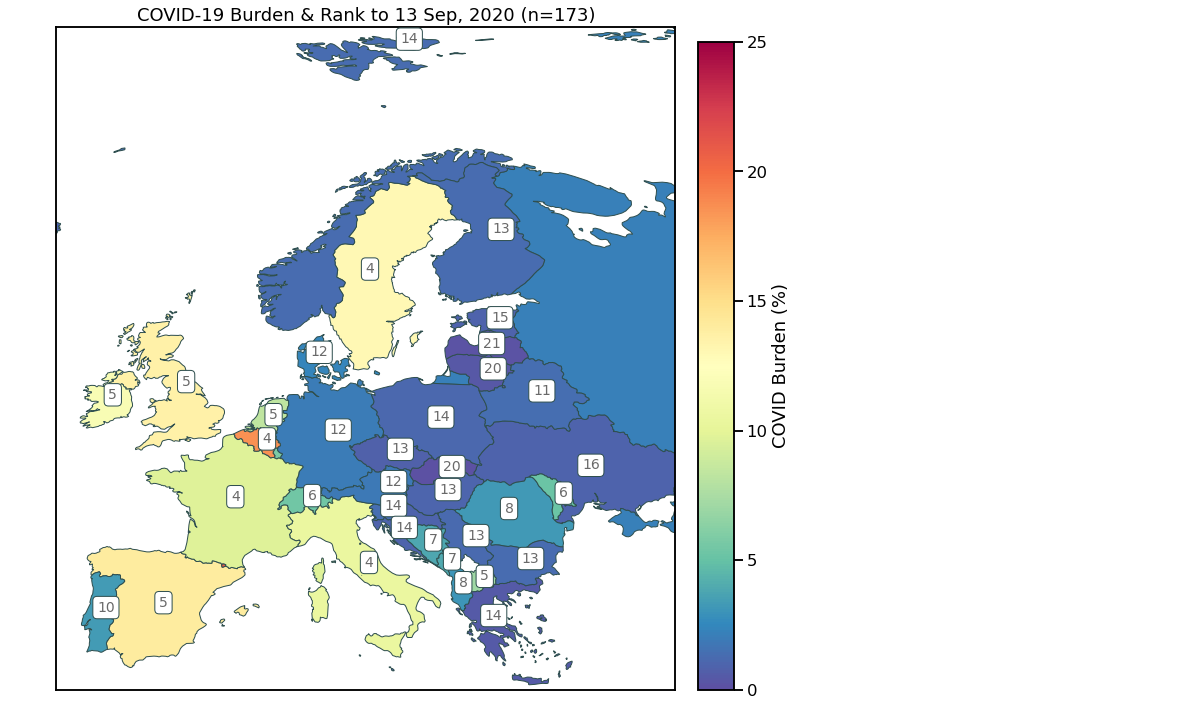

In [324]:
fig, ax = plt.subplots(figsize=(20, 20))

europe_map = map_with_data[map_with_data['continent']=='Europe']

europe_map.plot(
    column='covid_burden', cmap=use_palette, norm=norm, ax=ax, lw=1, edgecolor='darkslategrey')

min_area = 1e10

europe_map[europe_map['covid_rank'].notnull()].apply(
    lambda row: ax.annotate(
        '{}'.format(int(row['covid_rank'])), xy=row['coords'], fontsize=14, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)
    
    
ax.set_xlim(-.1e7,0.32e7)
ax.set_ylim(3.7e6, 8.2e6)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

cax = fig.add_axes([.48, .27, 0.025, .45])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')


fig.tight_layout()

ax.set_title('COVID-19 Burden & Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))



fig.savefig('graphs/covid_burden_europe_map.png', dpi=300, format='png', bbox_inches='tight')

As expected, the harder hit European countries are associated with much lower COVID ranks than other European nations, particularly those in eastern Europe.

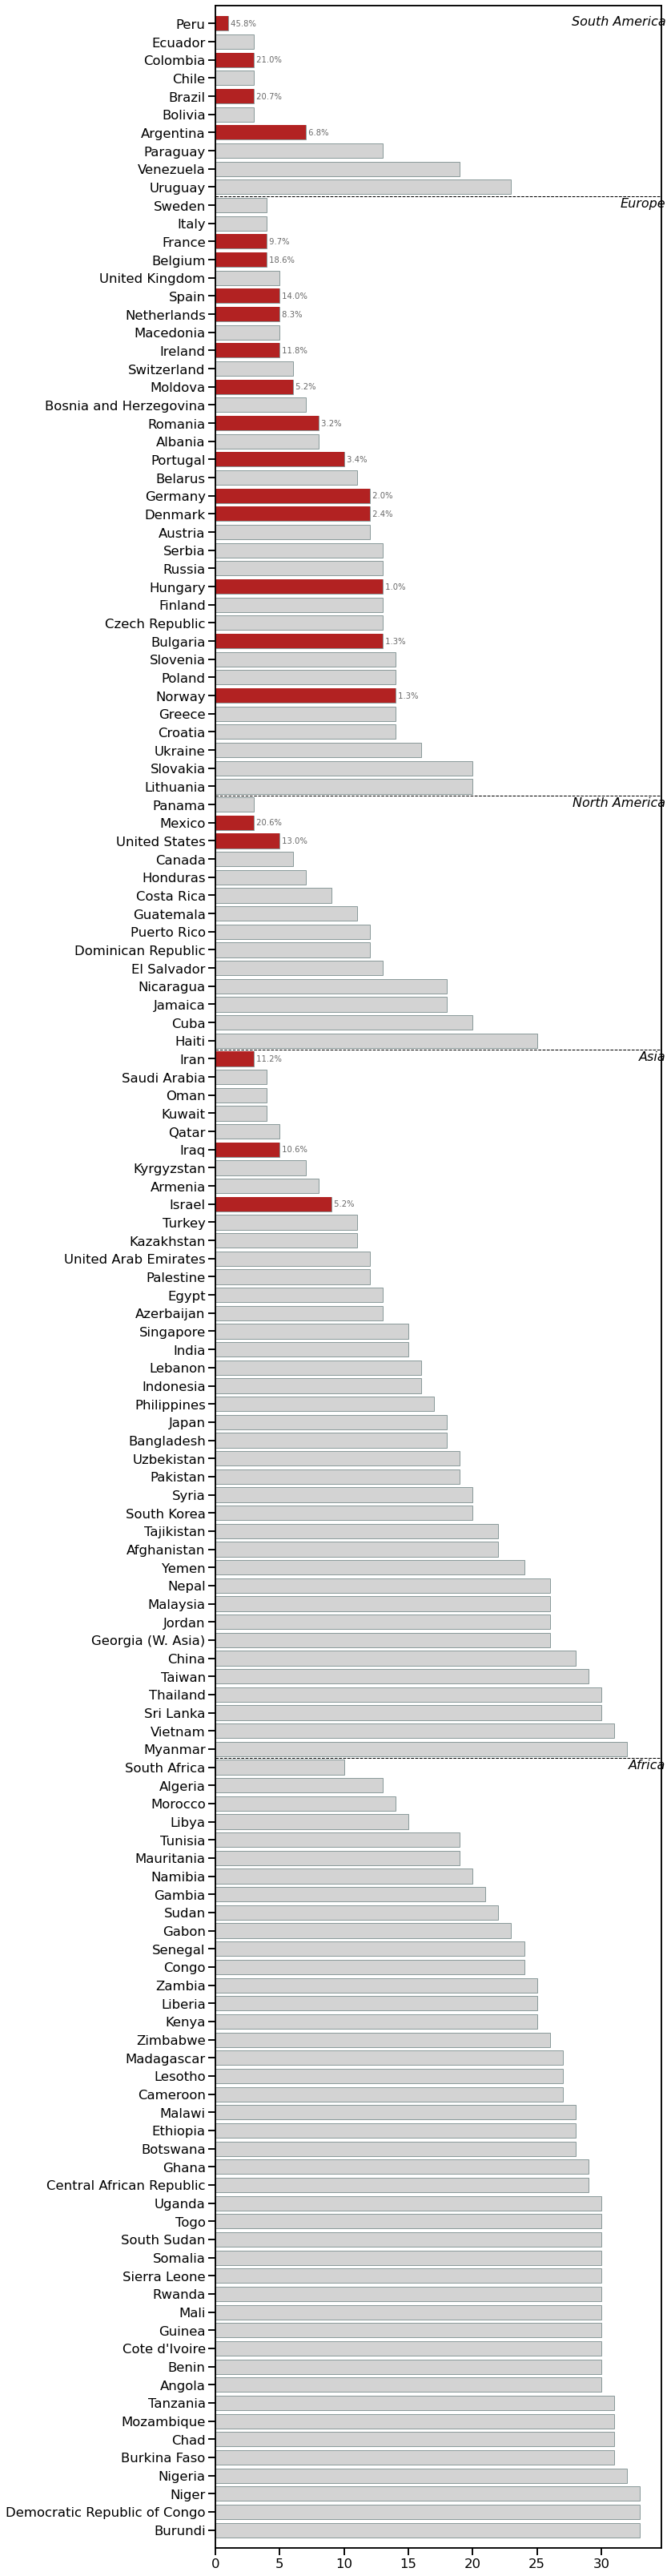

In [325]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 45))

min_pop = 2000000
with_min_pop = current_df['population']>min_pop

data_with_continent_burden = current_df[with_min_pop].reset_index().set_index('continent')\
    .join(pd.DataFrame(burden_by_continent.drop('Oceania')['covid_rank']['mean']).rename(columns={'mean':'mean_covid_rank_continent'}), how='inner')\
    .reset_index().set_index('country_code')\
    .sort_values(by=['mean_covid_rank_continent', 'covid_rank'], ascending=False)


ax.barh(data_with_continent_burden['country'], data_with_continent_burden['covid_rank'], color='lightgrey', edgecolor='darkslategrey', lw=.5)

highlight_countries = data_with_continent_burden['country'].isin(show_countries)

ax.barh(data_with_continent_burden[highlight_countries]['country'], data_with_continent_burden[highlight_countries]['covid_rank'], color='firebrick')


# Annotate the bars.
for _, (_, row) in enumerate(data_with_continent_burden[highlight_countries].iterrows()):
    x = row['covid_rank']
    y = row['country']
    v = row['covid_burden']
    ax.text(x, y, ' {}%'.format(round(v, 1)), fontsize=10, color='dimgrey', va='center')

# Add the Continent Labels
base = 0
for continent in data_with_continent_burden['continent'].unique():
    if base>0: ax.axhline(base-.5, lw=1, c='k', ls='--')
    base += len(data_with_continent_burden[data_with_continent_burden['continent']==continent])
    ax.text(35, base-1.1, continent, ha='right', fontsize=16, style='oblique')

ax.set_ylim(-1, len(data_with_continent_burden))
fig.tight_layout()



In [326]:
causes_of_death_by_country[causes_of_death_by_country['country']=='Ireland'].filter(
    like='(deaths)').T.sort_values(by=88, ascending=False)

,88
Cardiovascular diseases (deaths),9681.449297
Cancers (deaths),9580.528191
Dementia (deaths),2698.251777
Respiratory diseases (deaths),2225.938870
Lower respiratory infections (deaths),1371.932621
Digestive diseases (deaths),1144.509391
Kidney disease (deaths),579.037342
Suicide (deaths),452.874596
Diabetes (deaths),419.523390
Liver diseases (deaths),392.544344
